In [1]:
import numpy as np
import sys, os
cwd_split = os.getcwd().split(os.sep)
root = os.path.abspath("")
sys.path.insert(0, f"{root}/build/python")

import mitsuba as mi
# mi.set_variant("cuda_ad_rgb")
mi.set_variant('llvm_ad_rgb_double','cuda_ad_rgb_double')
import drjit as dr
import matplotlib.pyplot as plt
def plot_list(images, title=None):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 3))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')
    if title is not None:
        plt.suptitle(title)

from gaussnewton_test import conjugate_gradient, AlbedoScene

In [2]:
# Rendering resolution
render_res = 32

# Number of stages
num_stages = 1

# Number of training iteration per stage
num_iterations_per_stage = 10

# learning rate
learning_rate = 0.2

# Initial grid resolution
grid_init_res = 16

# Spherical harmonic degree to be use for view-dependent appearance modeling
sh_degree = 2

# Enable ReLU in integrator
use_relu = True

# Number of sensors
sensor_count = 7
sensor_dict = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': render_res * sensor_count, 'height': render_res,
        'filter': {'type': 'box'},
        'pixel_format': 'rgba'
    }
}

#sensors = []

for i in range(sensor_count):
    angle = 360.0 / 7 * i
    sensor_dict[f"sensor_{i}"] = {
        'type': 'perspective',
        'fov': 45,
        'to_world': mi.ScalarTransform4f.translate([0.5, 0.5, 0.5]) \
                                        .rotate([0.8, -0.6, 0], angle)   \
                                        .look_at(target=[0, 0, 0],
                                                 origin=[0, 0, 1.3],
                                                 up=[0, 1, 0])
    }
sensor = mi.load_dict(sensor_dict)

def plot_batch_output(out: mi.TensorXf):
    fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
    ax.imshow(mi.util.convert_to_bitmap(out))
    ax.axis('off');

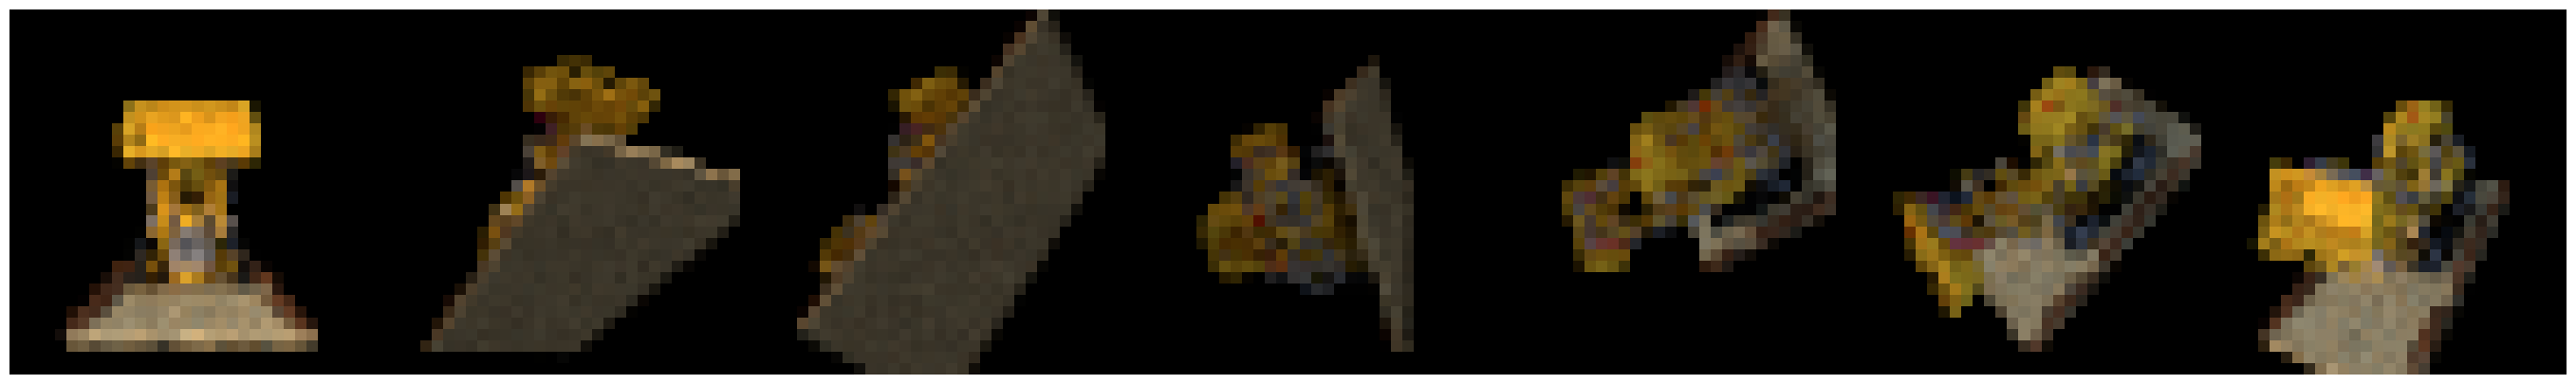

In [3]:
scene_ref = mi.load_file('./tutorials/scenes/lego/scene.xml')
ref_images = mi.render(scene_ref, sensor=sensor, spp=64)
plot_batch_output(ref_images)

In [4]:
class RadianceFieldPRB(mi.ad.common.RBIntegrator):
    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.bbox = mi.ScalarBoundingBox3f([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
        self.use_relu = use_relu
        self.grid_res = grid_init_res
        # Initialize the 3D texture for the density and SH coefficients
        res = self.grid_res
        self.sigmat = mi.Texture3f(dr.full(mi.TensorXf, 0.9, shape=(res, res, res, 1)))
        self.sh_coeffs = mi.Texture3f(dr.full(mi.TensorXf, 0.6, shape=(res, res, res, 3 * (sh_degree + 1) ** 2)))

    def eval_emission(self, pos, direction):
        spec = mi.Spectrum(0)
        sh_dir_coef = dr.sh_eval(direction, sh_degree)
        sh_coeffs = self.sh_coeffs.eval(pos)
        for i, sh in enumerate(sh_dir_coef):
            spec += sh * mi.Spectrum(sh_coeffs[3 * i:3 * (i + 1)])
        return dr.clip(spec, 0.0, 1.0)

    def sample(self, mode, scene, sampler,
               ray, δL, state_in, active, **kwargs):
        primal = mode == dr.ADMode.Primal

        ray = mi.Ray3f(ray)
        hit, mint, maxt = self.bbox.ray_intersect(ray)

        active = mi.Bool(active)
        active &= hit  # ignore rays that miss the bbox
        if not primal:  # if the gradient is zero, stop early
            active &= dr.any(dr.neq(δL, 0))

        step_size = mi.Float(1.0 / self.grid_res)
        t = mi.Float(mint) + sampler.next_1d(active) * step_size
        L = mi.Spectrum(0.0 if primal else state_in)
        δL = mi.Spectrum(δL if δL is not None else 0)
        β = mi.Spectrum(1.0) # throughput

        loop = mi.Loop(name=f"PRB ({mode.name})",
                       state=lambda: (sampler, ray, L, t, δL, β, active))
        while loop(active):
            p = ray(t)
            with dr.resume_grad(when=not primal):
                sigmat = self.sigmat.eval(p)[0]
                if self.use_relu:
                    sigmat = dr.maximum(sigmat, 0.0)
                tr = dr.exp(-sigmat * step_size)
                # Evaluate the directionally varying emission (weighted by transmittance)
                Le = β * (1.0 - tr) * self.eval_emission(p, ray.d)
                if not primal:
                    dr.backward_from(δL * (L * tr / dr.detach(tr) + Le))
            β *= tr
            L = L + Le if primal else L - Le
            t += step_size
            active &= (t < maxt) & dr.any(dr.neq(β, 0.0))

        return L if primal else δL, mi.Bool(True), L

    def traverse(self, callback):
        callback.put_parameter("sigmat", self.sigmat.tensor(), mi.ParamFlags.Differentiable)
        callback.put_parameter('sh_coeffs', self.sh_coeffs.tensor(), mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        self.sigmat.set_tensor(self.sigmat.tensor())
        self.sh_coeffs.set_tensor(self.sh_coeffs.tensor())
        self.grid_res = self.sigmat.shape[0]

mi.register_integrator("rf_prb", lambda props: RadianceFieldPRB(props))

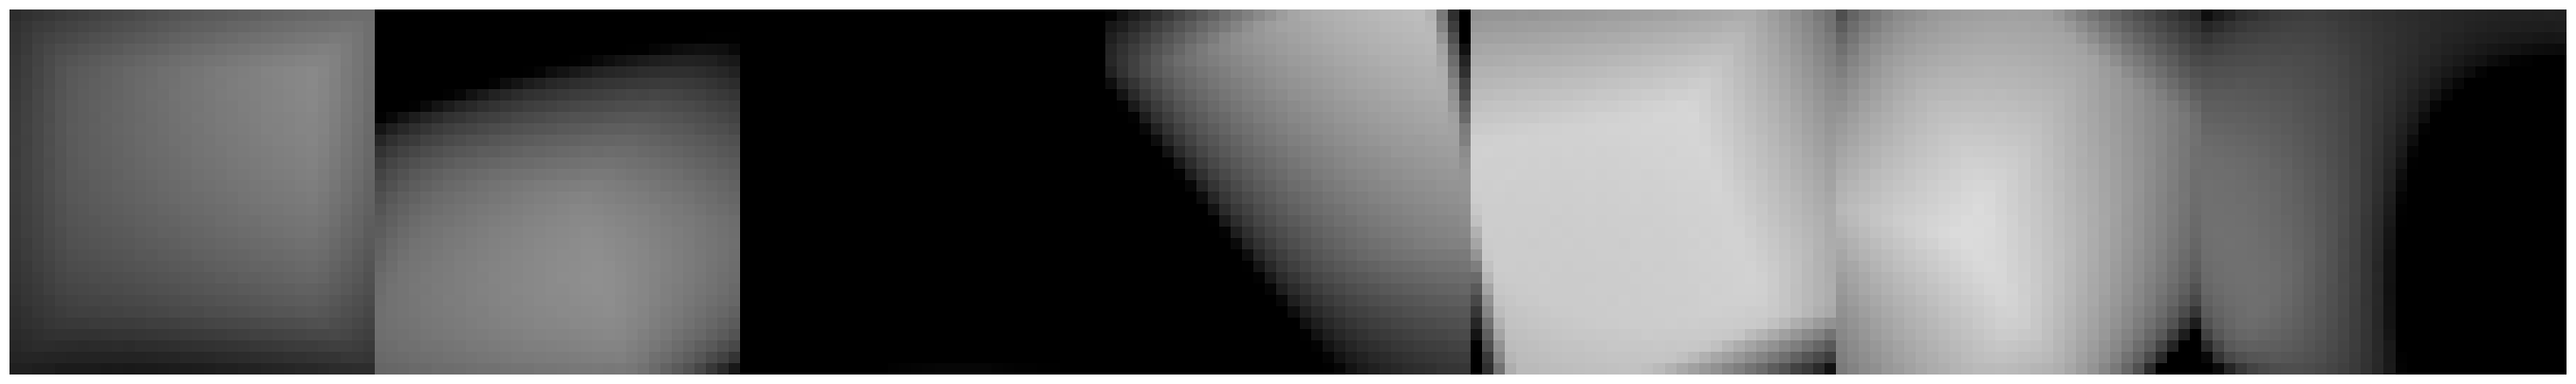

In [5]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'rf_prb'
    },
    'emitter': {
        'type': 'constant'
    }
})
integrator = scene.integrator()

# Render initial state
init_images = mi.render(scene, sensor=sensor, spp=128)
plot_batch_output(init_images)

In [6]:
params = mi.traverse(integrator)
# opt = mi.ad.Adam(lr=learning_rate, params={'sigmat': params['sigmat'], 'sh_coeffs': params['sh_coeffs']})

# params.update(opt);

keys = {'sigmat', 'sh_coeffs'}
experiment_idx = -1
sc = AlbedoScene(scene, params,  keys, sensor, ref_images = ref_images, _EXP_IDX = experiment_idx)

dr.set_flag(dr.JitFlag.LoopRecord, False)
dr.set_flag(dr.JitFlag.VCallRecord, False)

losses = []
intermediate_images = []

for stage in range(num_stages):
    #print(f"Stage {stage+1:02d}, feature voxel grids resolution -> {opt['sigmat'].shape[0]}")
    image, loss = sc.eval_func()
    for it in range(num_iterations_per_stage):
        total_loss = mi.Float(0.0)
        images = []
        
        # Compute the Gauss-Newton descent direction
        descent_dir = conjugate_gradient(sc.values(), loss, sc)
        print("descent direction: ", dr.sum(dr.abs(descent_dir)))
        # Optimizer: take a Gauss Newton descent step
        sc.step(descent_dir)

        # Compute the loss using the current parameter values
        image, loss = sc.eval_func()
        print("loss = ", loss)
        
        total_loss += loss[0]

        # Store images at the end of every stage
        if it == num_iterations_per_stage - 1:
            dr.eval(image)
            images.append(image)
        
        if not integrator.use_relu:
            params['sigmat'] = dr.maximum(params['sigmat'], 0.0)

        #params.update()
        #dr.backward(total_loss)
        losses.append(total_loss)
        
        print(f"  --> iteration {it+1:02d}: error={total_loss[0]:6f}", end='\n')
        
        # total_loss = mi.Float(0.0)
        # params.update(opt)
        
        # img = mi.render(scene, params, sensor=sensor, spp=1, seed = it)
        
        # #print("start ", it)
        # loss = dr.mean(dr.abs(img - ref_images))
        
        # dr.backward(loss)
        
        # # if it == num_iterations_per_stage - 1:
        # #     dr.eval(img)
            
        # losses.append(loss)
        
        
        # opt.step()
        # #print("end ", it)
        # if not integrator.use_relu:
        #     opt['sigmat'] = dr.maximum(opt['sigmat'], 0.0)

        #print(f"  --> iteration {it+1:02d}: error={loss[0]:6f}", end='\r')

    intermediate_images.append(images)

    # Upsample the 3D textures at every stage
    # if stage < num_stages - 1:
    #     new_res = 2 * opt['sigmat'].shape[0]
        
    #     new_shape = [new_res, new_res, new_res]
    #     opt['sigmat']   = dr.upsample(opt['sigmat'],   new_shape)
    #     opt['sh_coeffs'] = dr.upsample(opt['sh_coeffs'], new_shape)
        
    #     params.update(opt)

print('')
print('Done')

114688
dHd:  [-2.8249844048317915e-07]
d:  [-6.887844868118948e-07, -8.023247714277129e-07, -8.965375036911721e-06, -1.38272191025615e-05, -1.1543029144641208e-05, .. 114678 skipped .., -2.3789096644336705e-08, 9.092276304041184e-09, 4.1889187515785e-09, 4.251365180158087e-09, 6.413767430027043e-09]
Hd:  [5.461605086088548e-07, 6.361904392775781e-07, 7.108949001875593e-06, 1.0964069549033767e-05, 9.152858098916243e-06, .. 114678 skipped .., 1.8863179080518782e-08, -7.209573307337696e-09, -3.3215353128416964e-09, -3.371051197486104e-09, -5.0856930560328985e-09]
descent direction:  [0.11980365060308597]
loss =  [0.3152836285784608]
  --> iteration 01: error=0.315284
dHd:  [-2.824976926803107e-07]
d:  [-6.887879006329439e-07, -8.023284631902673e-07, -8.965342834348753e-06, -1.3827137317181084e-05, -1.1542951563282374e-05, .. 114678 skipped .., -2.3789111767165338e-08, 9.092396545777979e-09, 4.188898366194204e-09, 4.251345047332559e-09, 6.413756212367094e-09]
Hd:  [5.461652922945324e-07, 6

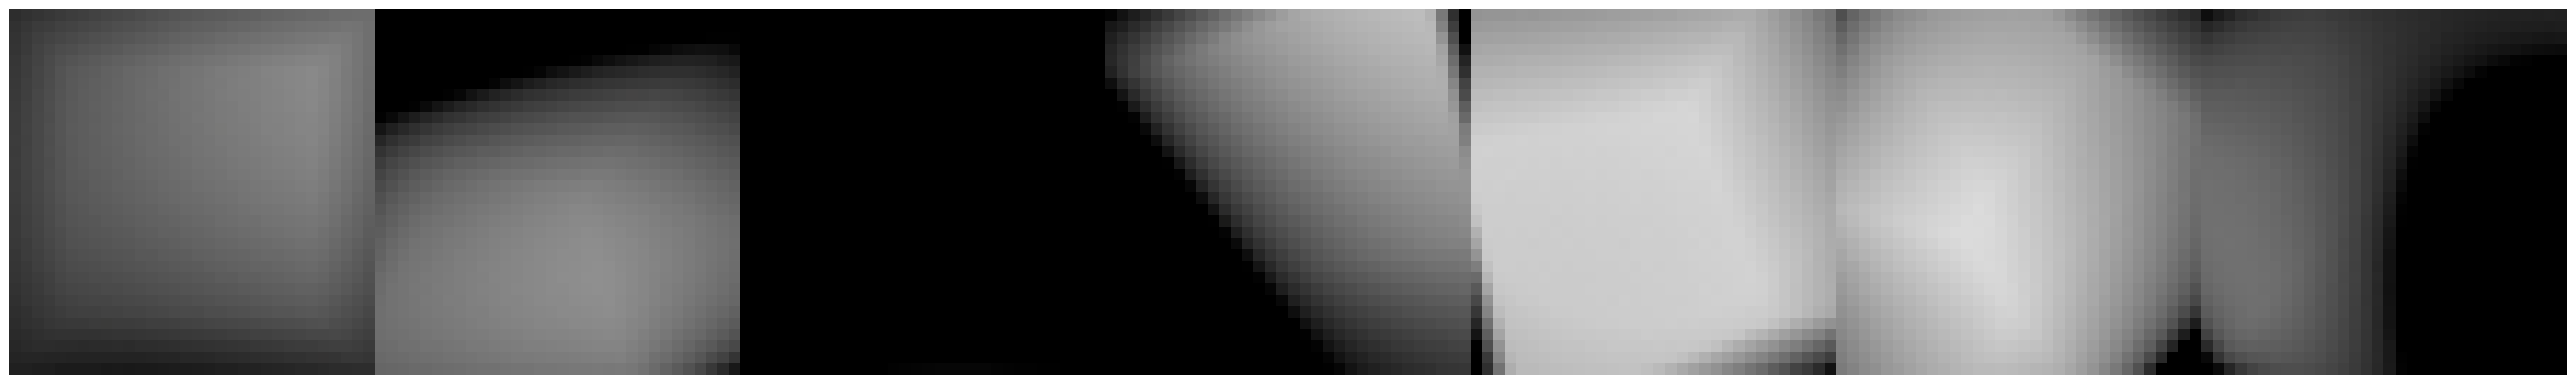

In [7]:
final_images = mi.render(scene, sensor=sensor, spp=128)
# for stage, inter in enumerate(intermediate_images):
#     plot_list(inter, f'Stage {stage}')
# plot_list(final_images, 'Final')
# plot_list(ref_images, 'Reference')
plot_batch_output(final_images)